# (some) Related Work

- Solving Inverse PDE Problems using Grid-Free Monte Carlo Estimators
- Path Replay Backpropagation: Differentiating Light Paths using Constant Memory and Linear Time
- Monte Carlo Geometry Processing: A Grid-Free Approach to PDE-Based Methods on Volumetric Domains
- Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients
- Sparsified Randomization Algorithms for large systems of linear equations and a new version of the Random Walk on Boundary method


# Abstract
We briefly talk about bad variance behavior of RMC. Introduce next flight (RRMC) and coupled recursion. Discuss possible ways to implement recursion in python and then finish of with local models via SALT.


# Interesting Examples  
We haven't addressed which integral equations produce well behaving estimators. Following examples show some bad behavior.

## Example 1

Bad example of turning a non recursive integral equation into a recursive one:

$$
\begin{align*}
e^{t} &= 1 + \int_{0}^{t} y(s) ds \Leftrightarrow\\
y(t)  &= 1 + \int_{0}^{t} y(s) ds - e^{t} + y(t)
\end{align*}
$$

then use russian roulette to remove branching. We think that it is impossible to turn this last recursive integral equation into a finite variance estimator directly.


In [19]:
from random import random, randint
from math import exp


def Y(t, q):  # t<1
    k = randint(1, 3)
    if k == 1:
        return q*(1 - exp(t))+1+t
    if k == 2:
        return q*(1 - exp(t)) + 3*(Y(t, q)-1-t)
    return q*(1 - exp(t) + 3*t*Y(random()*t, q))


sol = 0
nsim = 10**1
t = 0.5  # <1

for _ in range(nsim):
    sol += Y(t, -0.1)/nsim

s = exp(t)  # analytic solution
percentage_error = (sol - s)/s

print(f"sol({t}) is approx = {sol}")
print(f"%error = {percentage_error}")


sol(0.5) is approx = -0.7605162916145758
%error = -1.4612764480751943


## Example 2

Alternative approach for ODE example in period 2

$$
\begin{aligned}
y''&=y  \Leftarrow \\
y'(t)&=y'(1)-\int_{t}^{1} y(s)ds \Leftarrow\\
y(t)&=y(0)+t y'(1)-\int_0^t \int_s^1 y(l) d l d s
\end{aligned}
$$

with $y(0)=1, y'(1) = e$ such that the solution is $y(t) = e^{t}$. The implementation uses Russian Roulette:


In [20]:
from random import random
from math import exp


def Y(t):  # 0<t<1
    S = random()*t
    L = 1-(1 - S)*random()
    return 1 + t*exp(1) - 2 * t * (1-S) * Y(L) if random() < 1/2 else 1 + t*exp(1)


sol = 0
nsim = 10**4
t = 0.5  # <1

for _ in range(nsim):
    sol += Y(t)/nsim

s = exp(t)  # analytic solution
percentage_error = (sol - s)/s

print(f"sol({t}) is approx = {sol}")
print(f"%error = {percentage_error}")


sol(0.5) is approx = 1.666418107956915
%error = 0.010733674376185961


If you now increase the domain to $[0,2]$ the variance explodes (we conjecture that the variance abides a ODE and exists):

In [21]:
from random import random 
from math import exp

def Y(t): # 0<t<2
    S = random()*t
    L = 2-(2 - S)*random()
    if t<1:
        return  1 + t*exp(2) - (2-S)* Y(L) if random()<t else  1 + t*exp(2)  
    return  1 + t*exp(2) - t*(2-S)* Y(L) 

sol = 0
nsim = 10**2
t = 0.5 # <2

for _ in range(nsim):
    sol += Y(t)/nsim

s = exp(t) #analytic solution
percentage_error = (sol - s)/s

print(f"sol({t}) is approx = {sol}")
print(f"%error = {percentage_error}")

sol(0.5) is approx = 217745069.3372903
%error = 132069059.55431978


## Mini Conclusion
You have to be careful to get good properties when using RMC. Even if the variance exist, it may be unreasonably high. There are multiple ways to get the variance down to the reasonable levels importance sampling, using physical interpretations, next flight (see later),...

# Next Flight (Recursion in Recursion)
The idea behind next flight or something more general is recursion in recursion like the induction in induction proofs we love. By recursion in recursion we mean using a recursion for solving an other recursion step, $1$ slow recursion, $1$ fast recursion or $1$ outer recursion, $1$ inner recursion. <br>

In Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients they implement a next flight for walk on spheres and they talk about small walks = fast recursion in a big walk = slow recursion. <br>

Lets look at following example:
$$
y'=y, y(0)=1.
$$
with solution $y(t)=e^{t}$ this can be turned in following integral equation:
$$
y(t)= y(T) +  \int_{T}^{t}y(s)ds   
$$ 
in the slow recursion we estimate $y(T)$ with a call to the fast recursion using that estimate we estimate the integral with RMC leading to a fast recursion and the base case is the initial condition. (maybe that is still confusing ...) <br>

Implementation of this looks like:

In [8]:
from random import random
from math import exp


def Y_fast(t, T, yT, DT):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    return yT + DT*Y_fast(S, T, yT, DT) if random() < (t-T)/DT else yT


def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 0 else 0  # TT is where we are recursing to
    return Y_fast(T, TT, Y_slow(TT, DT), DT) if T > 0 else 1


# the convergence speeds is probably O(DT/sqrt(nsim))
# careful python has a max recursion dept until it crashes
s = 0
t = 50
DT = 0.05
nsim = 10**2

for _ in range(nsim):
    s += Y_slow(t, DT)/nsim

sol = exp(t)
err = (s-sol)/sol
print(f"res = {s}, ", f"%error= {err}")


res = 5.194175488565548e+21,  %error= 0.001826518386871069


We call this RRMC (= Recursion in Recursion Monte Carlo) for ODEs. We conjecture that this implementation of RRMC has similar properties as the Euler scheme. We look into high order/implicit methods in $DT$ later (maybe imitating other existing methods).

# Coupled Recursion
The idea of coupled recursion is combining multiple recursion processes together in a way they can use each others recursion calls. An example of coupled recursion can be found in Solving Inverse PDE Problems using Grid-Free Monte Carlo Estimators they calculate derivatives by replaying a path and estimates of the solution in other words they combine the solution process with the derivative process and the derivative process uses the solution process.(their implementation is a forward one we deal with recursion implementation problems later) <br>

In following example we implement a coupled solution and derivative process of the following problem:
$$
y'=ay,y(0)=1,a=1.
$$ 
This has as solution $y(t,a) = e^{at}$ and is equivalent with following integral equation:
$$
y(t,a) = 1 + \int_{0}^{t} a y(s,a)ds .
$$ 
Differentiating this in $a$ gives
$$
\partial_{a} y(t,a) = \int_{0}^{t} y(s,a) + a \partial_{a} y(t,a) ds .
$$ 
if you simulate this last expression you get a branching estimator this can be avoided by russian roulette but also by combining it with the first equation and sharing recursions (writing it as a vector is a nice way to emphasize coupled recursion):

$$ 
\left(\begin{array}{l}
y(t, a) \\
\partial_a y(t, a)
\end{array}\right)=\left(\begin{array}{l}
1 \\
0
\end{array}\right)+\int_0^t\left(\begin{array}{l}
a y(s, a) \\
y(s, a)+a \partial_{a}y(s, a)
\end{array}\right) d s
$$
Turning that into a recursive estimator implemented in code it looks like this:

In [96]:
from random import random
from math import exp
import numpy as np

# E for estimator
def E(t, a) -> np.array:
    if t < 1 and random() > t:
        return np.array([1, 0])
    ys, dys = E(random()*t, a)
    y = 1 + t*a*ys if t > 1 else 1 + a*ys
    py = t*(ys+a*dys) if t > 1 else ys+a*dys
    return np.array([y, py])


def test():
    s = np.array([0.0, 0.0])
    nsim = 10**4
    t, a = 0.5, 3
    for _ in range(nsim):
        s += E(t, a)/nsim

    sol = np.array([exp(t*a), t*exp(t*a)])
    err = (s-sol)/sol
    print(f"E = {s}",f"%error is {err}")

test()

E = [4.5241 2.2208] %error is [ 0.00946316 -0.00894508]


We also did the example of RMC exp Dy of period2 (see tests). We have a crazy idea of an example of a boundary problem ODE where we combine coupled recursion with recursion in recursion (that we maybe implement next period).

# Inverse Problem
Following Solving Inverse PDE Problems using Grid-Free Monte Carlo Estimators and last example + stochastic gradient descent gives you an inverse solver.<br>

Lets say we want to fit $y(t,a,b)$ to a function $d$ where $y(t,a,b)$ is the solution of
$$
y'=ay, y(0)=b
$$ 
using the following integral representation:
$$
y(t,a,b)= b + \int_{0}^{t} a y(s,a,b)ds .
$$ 
We can formulate this as an optimization problem
$$
\alpha, \beta = \text{argmin}_{a,b}||y(t,a,b)-d(t)||_{2}^{2}.
$$ 
The gradient of the $L2$ score is:

$$
\nabla f(a,b)=2 
\left(\begin{array}{l}
\int_{0}^{1} (y(s)-d(s)) \partial_{a} y(s) ds\\ 
\int_{0}^{1} (y(s)-d(s)) \partial_{b} y(s) ds
\end{array}\right)
$$ 
We already have an integral equation for $y(s)$ the one for $\partial_{a}y(s)$ and $\partial_{b} y(s)$ can be obtained by taking the derivative of it:

$$
\begin{align*}
\partial_{a} y(s) &= \int_{0}^{t} y(s) + a \partial_{a} y(s) ds \\     
\partial_{b} y(s) &= 1+ \int_{0}^{t} a \partial_{b} y(s) ds \\     
\end{align*}
.
$$ 
this first integral equation we already dealt with (see coupled recursion) and the second one is pretty easy.


[0.95747509 1.95390802]


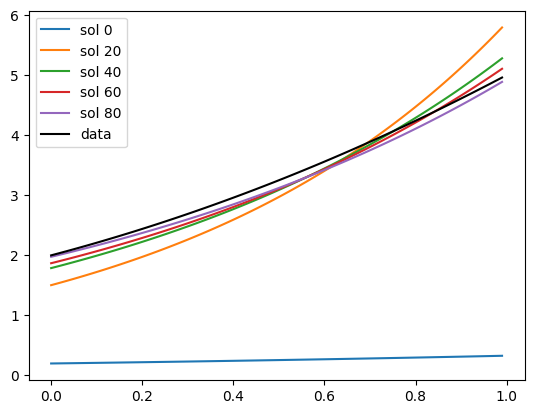

In [9]:
from random import random
import numpy as np
from math import exp
import matplotlib.pyplot as plt

def d(x):
    return (1+x+x**2/2)*2

def E(t,a,b)->np.array: # the second term is an estimator for parial_a y 
    if t<1 and random()>t:
        return np.array([1,0])
    e = E(random()*t,a,b)
    y = b + t*a*e[0] if t>1 else b + a*e[0]
    day= t*(e[0]+a*e[1]) if t>1 else e[0]+a*e[1]
    return np.array([y,day])
    
def dby(t,a,b):
    if t>1:
        return  1 + a* t*dby(random()*t,a,b) 
    return 1 + a* dby(random()*t,a,b) if random()<t else 1

def y(t,a,b):
    if t>1:
        return b + a*t*y(t,a,b)
    return b + a* y(random()*t,a,b) if random()<t else b

def grad_f(a,b):
    u = random()
    r = y(u,a,b)- d(u)
    daf = r*E(u,a,b)[1] 
    dbf = r*dby(u,a,b) 
    return np.array([daf,dbf])
    

xs = np.arange(0,1,0.01)
var = np.array([0.5,0.2])
for j in range(100):
    a,b = var
    s = 0
    nsim = 10**2
    for _ in range(nsim):
        s += grad_f(a,b)/nsim
    var -=s/20
    if j%20==0:
        ys = [b*exp(a*x) for x in xs]
        plt.plot(xs,ys, label =f"sol {j}")
print(var)

zs = [d(x) for x in xs]
plt.plot(xs,zs, color = "black", label= "data")
plt.legend()
plt.show()


# Implementing Recursion
![recursion meme](https://res.cloudinary.com/practicaldev/image/fetch/s--kxXet7oK--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://cdn.hashnode.com/res/hashnode/image/upload/v1603041948043/85-ZuWcqb.jpeg)

Until now we have been implementing recursion with recursion. If possible it is preferred (performance wise) to implement a recursive solution with loops. The performance drops from recursion calls comes from storing intermediate operations and function calls. (our knowledge of computer science is lacking) <br> 

There are $3$ solutions we have in mind for implementing recursion:
1. Reverse path generation
2. Tail-recursion (https://stackoverflow.com/questions/33923/what-is-tail-recursion)
3. Forward path generation + storing (= path storing)

Reverse path generation is hands down the best if you can implement it ... <br>
Path storing is worse performance wise then tail-recursion but in tail-recursion we don't get intermediate recursion calls which in our application are unbiased estimates of the solution at other places (in function input space) which are useful. <br>

We think that there are interesting techniques to make path generation/storing more efficient (see for example on our work on Brownian motion). <br> 

We will implement Tail-recursion and forward path generation + storing for the example of coupled recursion. <br>

Implementing forward path generation is pretty straight forward. The storing will be happening on a stack. 

In [93]:
from random import random
from collections import deque
import numpy as np

def path_deq(t):
    res = deque([t])
    while random() < t:
        t *= random()
        res.append(t)
    return res

# E for estimator
def E(t, a) -> np.array:
    ys, dys, path = 0, 0, path_deq(t)
    while path:
        y = 1+a*ys if path[-1] < 1 else 1+path[-1]*a*ys
        dy = ys + a*dys if path[-1] < 1 else path[-1]*(ys + a*dys)
        ys, dys = y, dy
        path.pop()
    return np.array([y, dy])

def test():
    s = np.array([0.0, 0.0])
    nsim = 10**4
    t, a = 0.5, 1
    for _ in range(nsim):
        s += E(t, a)/nsim

    sol = np.array([exp(t*a), t*exp(t*a)])
    err = (s-sol)/sol
    print(f"E = {s}", f"%error is {err}")


test()


E = [1.6461 0.8236] %error is [-0.00158988 -0.0009227 ]


![tailrec](https://i.stack.imgur.com/52QrO.jpg) <br>
Implementing tail-recursion is annoying because python doesn't support it so we have to use loops. We accumulate intermediate addition work into an array sol and intermediate multiplication work in matrix weight W (in this example we could have used a scalar weight because we multiply the same matrix up to a scalar and then we could have used eigenvalue stuff).

$$
X = \left(\begin{array}{l}
1 \\
0
\end{array}\right)+
\int_0^t\left(\begin{array}{cc}
a & 0\\
1 & a
\end{array}\right) X d s
$$

writing
$q=\left(\begin{array}{l}
1 \\
0
\end{array}\right)$ and
$
A =
\left(\begin{array}{cc}
a & 0\\
1 & a
\end{array}\right)
$ to simplify notation:

$$
X = q + \int_0^t AX d s .
$$


In [151]:
from random import random
from math import exp
import numpy as np


def X(t, a) -> np.array:
    q = np.array([1.0, 0.0])
    A = np.array([[a, 0.0], [1.0, a]])
    sol, W = np.array([1.0, 0.0]), np.identity(2)
    while random() < t:
        W = np.matmul(W, A) if t < 1 else t*np.matmul(W, A)
        sol += np.matmul(W, q)
        t *= random()
    return sol


def test():
    s = np.array([0.0, 0.0])
    nsim = 10**3
    t, a = 1.2, 0.9
    for _ in range(nsim):
        s += X(t, a)/nsim

    sol = np.array([exp(t*a), t*exp(t*a)])
    err = (s-sol)/sol
    print(f"E = {s}", f"%error is {err}")


test()


E = [2.90832443 3.43287554] %error is [-0.01234604 -0.02850902]


A related work to this is Path Replay Backpropagation: Differentiating Light Paths using Constant Memory and Linear Time. They have an other way. In our example they would calculate an estimate of $y(t)$ the tail-recursion way (so no intermediate estimates) then replay the path (pseudorandom with a seed) reconstructing intermediate estimates (when needed) because all operations backwards were invertible and then using those intermediate estimates to calculate the estimate of the derivative in a tail-recursion way. <br>

That is clever but they never needed the intermediated estimates they could have gone with plain tail-recursion (unless we brain farted somewhere). This trick they pulled of only works with $1$ way-coupling recursion in this case the derivative to the underlying.

We think it is also possible to combine those solutions although this can get clumsy really fast.
We will probably be using tail-recursion on inner iterations (when they are complicated or long otherwise regular recursion is better) and path storing on outermost iterations retaining at least some estimates and sacrificing minimal performance. In our example of RRMC the outer iterations happen on a grid so we could have also gotten away with reverse path generation.

# Local Model Via SALT
Instead of capturing local information with derivatives we could have also fitted an other local additive model. We will focus on one fitted with SALT. This has the advantage that it is more general in how local it is or it may capture non smooth behavior and could in principle use different type of unbiased information of the solution or in a special case only unbiased estimates of the solution. <br> 

We have a modified version of this in thoughts that can be used to calculate optimal non-local hedging strategies for big portfolios with the same benefits as the greek such as unbiased additivity but with bigger rehedging intervals.<br>

We will look again at the same example:
$$
y'=ay,y(0)=1,a=1
$$ 
This has solution $y(t)=e^{at}$ with $a=1$. In this example we're interested in the effect of small changes of $a$ for the solution at $t=1$. <br>

The information of small changes of $a$ is available in unbiased estimations of the solution with small changes in $a$. To capture this information we use those unbiased estimates to fit a function using SALT with Legendre polynomials.    

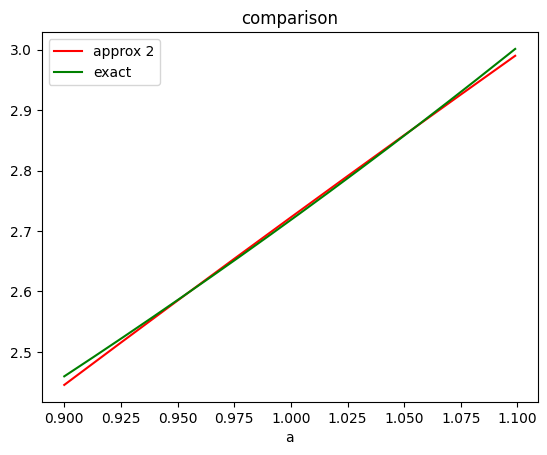

0.0015913331354945029


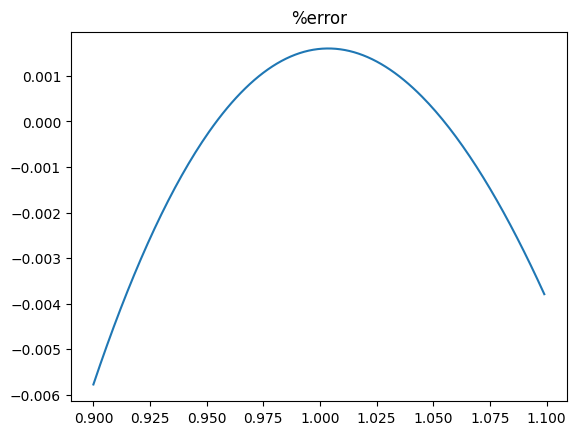

In [12]:
from random import random
import matplotlib.pyplot as plt
import numpy as np
from math import exp
from functools import lru_cache

#legendre polynomials
@lru_cache(maxsize=3)
def p(x,n):
    return ((2*n-1)*x*p(x,n-1)-(n-1)*p(x,n-2))/n if n>1 else (x if n ==1 else 1)

# can be more efficient using Clenshaw algorithm (https://en.wikipedia.org/wiki/Clenshaw_algorithm)
def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j)for j in range(len(a_control)))

def scale_down(x): # from [-1,1] to [0.9,1.1]
    return x/10+1

def scale_up(x): # from [0.9,1.1] to [-1,1]
    return 10*(x-1)

def Ya(t,a): #estimator for y(t,a)
    return (1+a*Ya(random()*t,a) if random()<t else 1) if t<1 else 1+t*a*Ya(random()*t,a)
    
def a_all(a_control,nsim=10):
    sol = [0]*len(a_control)
    for _ in range(nsim):
        u = (random()*2-1)
        ps = [p(u,j) for j in range(len(a_control))]
        aasol = sum(a*p for a,p in zip(a_control,ps)) 
        ff = Ya(1,scale_down(u)) 
        for n in range(len(a_control)):
            sol[n] += ((2*n+1)*(ff-aasol)*ps[n] + a_control[n])/nsim 
    return sol

a_control = [0]
order = 2

#we gradually add more and more coefficient you can think of it as somekind of regularization
while len(a_control)<order+2:
    a_control = a_all(a_control,5*10**4) 
    a_control.append(0)

def sol(x):
    return exp(x)
xs = np.arange(-1,1,0.01)
zs = [approx_sol(a_control,x) for x in xs]
xs = [scale_down(x) for x in xs]
ys = [sol(x) for x in xs ]
plt.plot(xs,zs, color= "red", label=f"approx {order}")
plt.plot(xs,ys, color= "green",label="exact")
plt.legend()
plt.xlabel("a")
plt.title("comparison")
plt.show()

xs = np.arange(-1,1,0.01)
print((approx_sol(a_control,0)-sol(scale_down(0)))/sol(scale_down(0)))
zs = [(approx_sol(a_control,x)-sol(scale_down(x)))/sol(scale_down(x)) for x in xs]
xs = [scale_down(x) for x in xs]
plt.plot(xs,zs)
plt.title("%error")
plt.show()

# TODO
- example RRMC on nonlinear ODE
- example RRMC+coupling on boundary ODE problem 
- russian roulette analysis
the rest you can find on the wishlist.